In [11]:
import os
from os import path
os.sys.path.append('../core/')
from mangle import *#cube_mangle
from astropy.io import fits
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
import astropy.units as u
from astropy.wcs import WCS
from copy import deepcopy
from calibrimbore.bill import get_skymapper_region
%matplotlib widget

from scipy.ndimage.filters import convolve
from scipy.ndimage import gaussian_filter
from copy import deepcopy

from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
import pandas as pd
from astroquery.vizier import Vizier

from scipy.optimize import minimize
import astropy.table as at

from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

def get_gaia_region(ra,dec,size=0.4, magnitude_limit = 21):
    """
    Get the coordinates and mag of all gaia sources in the field of view.

    -------
    Inputs-
    -------
        tpf 				class 	target pixel file lightkurve class
        magnitude_limit 	float 	cutoff for Gaia sources
        Offset 				int 	offset for the boundary 

    --------
    Outputs-
    --------
        coords 	array	coordinates of sources
        Gmag 	array 	Gmags of sources
    """
    c1 = SkyCoord(ra, dec, unit='deg')
    Vizier.ROW_LIMIT = -1

    result = Vizier.query_region(c1, catalog=["I/355/gaiadr3"],
                                     radius=Angle(size, "arcsec"),column_filters={'Gmag':f'<{magnitude_limit}'})

    keys = ['objID','RAJ2000','DEJ2000','e_RAJ2000','e_DEJ2000','gmag','e_gmag','gKmag','e_gKmag','rmag',
            'e_rmag','rKmag','e_rKmag','imag','e_imag','iKmag','e_iKmag','zmag','e_zmag','zKmag','e_zKmag',
            'ymag','e_ymag','yKmag','e_yKmag','tmag','gaiaid','gaiamag','gaiadist','gaiadist_u','gaiadist_l',
            'row','col']


    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise no_targets_found_message


    result = result['I/355/gaiadr3'].to_pandas()
    result = result.rename(columns={'RA_ICRS':'ra','DE_ICRS':'dec'})
    return result

/var/folders/db/hdghk6ts5g11hr10jq0ss625nf1ny2/T/ipykernel_16608/1433881232.py:18: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [179]:

c1 = SkyCoord([ra], [dec], unit='deg')
Vizier.ROW_LIMIT = -1

result = Vizier.query_region(c1, catalog=["II/371/des_dr2"],
                                 radius=Angle(50, "arcsec"))

In [180]:
result

Empty TableList

In [4]:
hdul = fits.open('2I_DATACUBE_FINAL_2019-12-31T06:22:04.886.fits')
wcs = WCS('2I_DATACUBE_FINAL_2019-12-31T06:22:04.886.fits')

hdul = fits.open('2I_DATACUBE_FINAL_2020-03-19T05:46:49.016.fits')
wcs = WCS('2I_DATACUBE_FINAL_2020-03-19T05:46:49.016.fits')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [5]:
wcs = WCS(hdul[1].header)
data = hdul[1].data

In [6]:
ra,dec, lam = wcs.all_pix2world(data.shape[2]/2,data.shape[1]/2,100,0)

In [7]:
#cat = get_skymapper_region([ra],[dec],size=100)
cat = get_gaia_region([ra],[dec],size=50)

In [8]:
x, y, lam = wcs.all_world2pix(cat.ra.values,cat.dec.values,0,0)

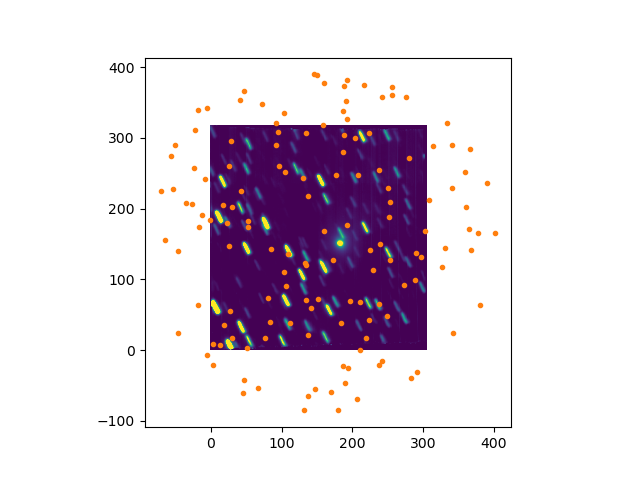

In [197]:
image = np.nanmean(data,axis=0)
image[np.isnan(image)] = 0
#image = gaussian_filter(image,3)
plt.figure()
plt.imshow(image,vmin=0,vmax=100,origin='lower')
plt.plot(x,y,'C1.')

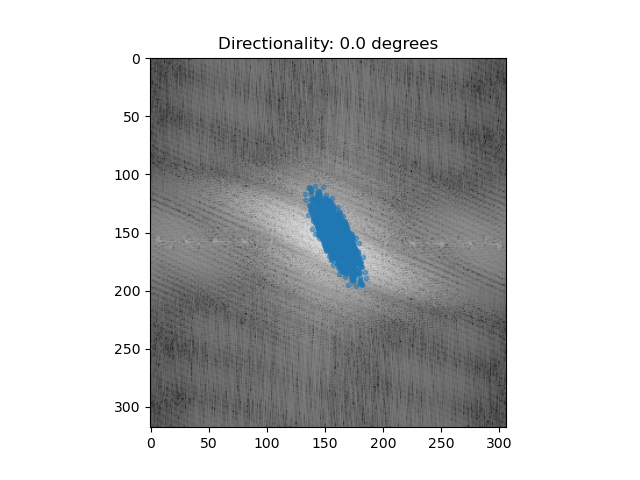

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = image

# Convert the image to grayscale
gray_img = img#np.mean(img, axis=2)

# Compute the 2D Fourier transform of the image
fft = np.fft.fft2(gray_img)

# Shift the zero-frequency component to the center of the spectrum
fft = np.fft.fftshift(fft)

# Compute the magnitude and power spectra
magnitude_spectrum = np.abs(fft)
power_spectrum = np.log10(np.square(magnitude_spectrum))

# Compute the orientation of each frequency component
orientation_spectrum = np.angle(fft)

# Create a meshgrid for the frequency domain axes
yfreq, xfreq = np.meshgrid(np.fft.fftfreq(gray_img.shape[0]), np.fft.fftfreq(gray_img.shape[1]))

# Plot the power spectrum as an image
plt.figure()
plt.imshow(power_spectrum, cmap='gray')

# Find the peak(s) in the power spectrum
peak_threshold = np.percentile(power_spectrum,99)#0.7 * np.max(power_spectrum)
peaks = np.where(power_spectrum >= peak_threshold)

# Compute the angle of the peak(s)
peak_angles = np.rad2deg(np.median(orientation_spectrum[peaks]))
plt.plot(peaks[0],peaks[1],'.',alpha=0.5)

# Draw a line indicating the direction of the peak(s)
#plt.plot([0, np.tan(np.deg2rad(peak_angles))], [-.5, .5], 'r-', linewidth=2)

# Show the image and the peak(s)
plt.title('Directionality: {} degrees'.format(peak_angles))
plt.show()


In [83]:
np.median(orientation_spectrum[peaks])

0.0

In [103]:
px = peaks[0] - np.mean(peaks[0])
py = -(peaks[1] - np.mean(peaks[1]))


In [181]:
m, c = np.polyfit(px, py, 1)
xx = np.arange(min(px),max(px)+1)

angle_radians = np.arctan2(m,1) # 1 is the length of the x-axis
# Convert the angle from radians to degrees
angle_degrees = -np.degrees(theta)

In [182]:
angle_degrees

51.259739250705664

In [183]:
m

-1.2464081396865625

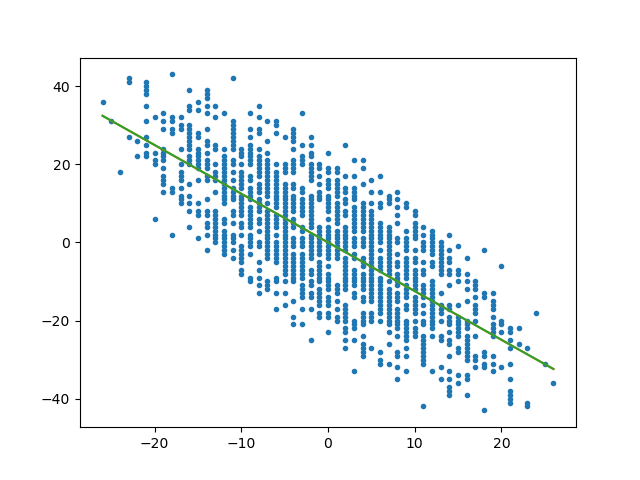

In [184]:
plt.figure()
plt.plot(px,py,'.')
plt.plot(xx,xx*slope+intercept)
plt.plot(xx,xx*m+c)

In [ ]:
ef unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

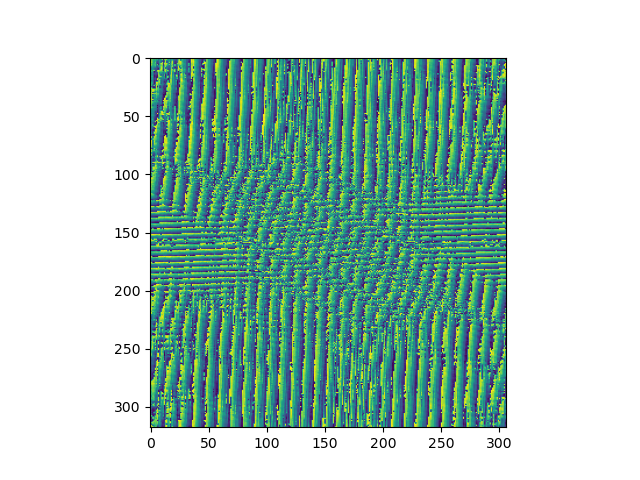

In [67]:
plt.figure()
plt.imshow(orientation_spectrum)


In [164]:
image = np.nanmean(data,axis=0)
image[np.isnan(image)] = 0
image = gaussian_filter(image,5)

In [165]:
mean, med, std = sigma_clipped_stats(image, sigma=3.0)

daofind = DAOStarFinder(fwhm=10,theta = angle_degrees,ratio=.5, threshold=3*std,exclude_border=True)
s = daofind(image - med)

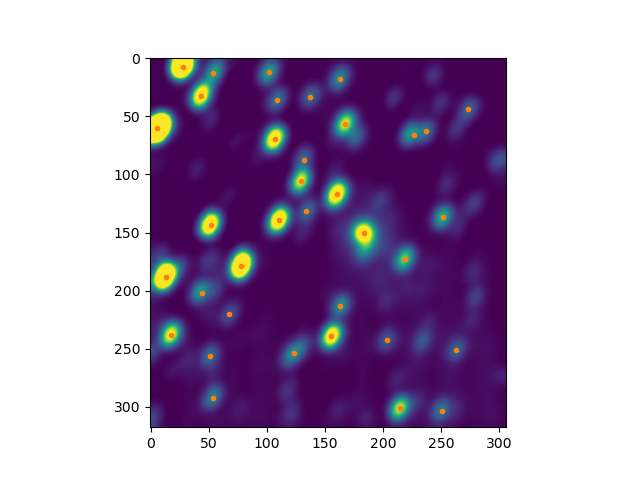

In [166]:
plt.figure()
plt.imshow(image,vmin=0,vmax=50)

plt.plot(s['xcentroid'],s['ycentroid'],'C1.')

In [167]:
sourcex = s['xcentroid']; sourcey = s['ycentroid']
i = 20
buffer = 4
lowy = int(sourcey[i]-buffer)
highy = int(sourcey[i]+buffer+1)
lowx = int(sourcex[i]-buffer)
highx = int(sourcex[i]+buffer+1)
if lowy < 0:
    lowy = 0
if lowx < 0:
    lowx = 0
thing = image[lowy:highy,lowx:highx]

np.where(thing == np.nanmax(thing))

(array([5]), array([4]))

In [169]:
def min_dist(x1,y1,x2,y2):
    dx = x1[:,np.newaxis] - x2[np.newaxis,:]
    dy = y1[:,np.newaxis] - y2[np.newaxis,:]
    d = np.sqrt(dx**2 + dy**2)
    md = np.nanmin(d,axis=1)
    return md

def minimize_dist(offset,x1,y1,x2,y2,image):
    cx = image.shape[1]/2; cy = image.shape[0]/2
    x = x1 + offset[0]
    y = y1 + offset[1]
    x = cx + ((x-cx)*np.cos(offset[2])-(y-cy)*np.sin(offset[2]))
    y = cy + ((x-cx)*np.sin(offset[2])+(y-cy)*np.cos(offset[2]))

    ind = (x > 0) & (x < image.shape[1]) & (y > 0) & (y < image.shape[0])
    x = x[ind]; y = y[ind]
    mdist = min_dist(x2,y2,x,y)
    return np.nanmean(mdist)

x0 = [0,0,0]

ind = cat['Gmag'].values < 20

x, y, lam = wcs.all_world2pix(cat.ra.values[ind],cat.dec.values[ind],0,0)

catx = x; caty = y
sourcex = s['xcentroid']; sourcey = s['ycentroid']

res = minimize(minimize_dist,x0,args=(catx,caty,sourcex,sourcey,image))

xx = x + res.x[0]
yy = y + res.x[1]
cx = image.shape[1]/2; cy = image.shape[0]/2
xx = cx + ((xx-cx)*np.cos(res.x[2])-(yy-cy)*np.sin(res.x[2]))
yy = cy + ((xx-cx)*np.sin(res.x[2])+(yy-cy)*np.cos(res.x[2]))

#ind = (xx > 0) & (xx < image.shape[1]) & (yy > 0) & (yy < image.shape[0])
#xx = xx[ind]; yy = yy[ind]

cut = min_dist(xx,yy,sourcex,sourcey) < 5
print('round 1: ',res.x)
res = minimize(minimize_dist,x0,args=(catx[cut],caty[cut],sourcex,sourcey,image))
print('round 2: ',res.x)


round 1:  [ 2.54794421e+01 -3.77603215e+00 -1.88835709e-03]
round 2:  [ 2.54957760e+01 -3.74466349e+00 -1.89042884e-03]


In [177]:
def transform_coords(x,y,param,image):
    xx = x + param[0]
    yy = y + param[1]
    cx = image.shape[1]/2; cy = image.shape[0]/2
    xx = cx + ((xx-cx)*np.cos(param[2])-(yy-cy)*np.sin(param[2]))
    yy = cy + ((xx-cx)*np.sin(param[2])+(yy-cy)*np.cos(param[2]))
    ind = (xx > 0) & (xx < image.shape[1]) & (yy > 0) & (yy < image.shape[0])
    xx = xx[ind]; yy = yy[ind]
    return xx, yy

Querying regions with Vizier


/var/folders/db/hdghk6ts5g11hr10jq0ss625nf1ny2/T/ipykernel_16608/3107633731.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaia['x'] = xx
/var/folders/db/hdghk6ts5g11hr10jq0ss625nf1ny2/T/ipykernel_16608/3107633731.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaia['y'] = yy


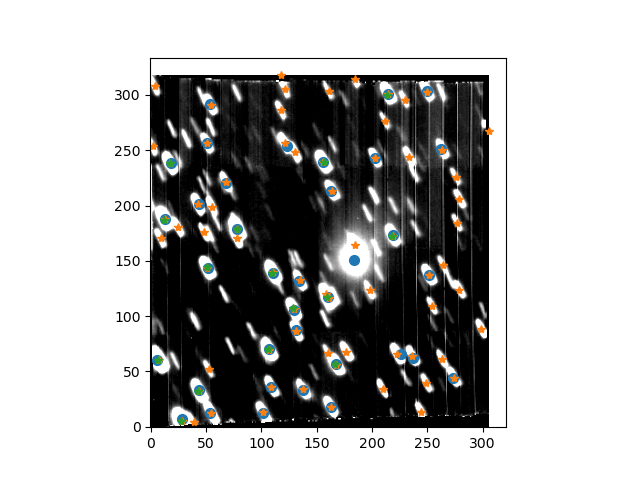

In [178]:
image = np.nanmean(data,axis=0)
image[np.isnan(image)] = 0
cat = get_gaia_region([ra],[dec],size=50,magnitude_limit=25)
sm = get_skymapper_region([ra],[dec],size=50)

x, y, lam = wcs.all_world2pix(cat.ra.values,cat.dec.values,0,0)
smx, smy, lam = wcs.all_world2pix(sm.ra.values,sm.dec.values,0,0)

xx,yy = transform_coords(x,y,res.x,image)
smx,smy = transform_coords(smx,smy,res.x,image)


gaia = cat.iloc[ind]
gaia['x'] = xx
gaia['y'] = yy

plt.figure()
plt.imshow(image,vmin=0,vmax=10,cmap='gray',origin='lower')
plt.plot(sourcex,sourcey,'o',ms=7)
plt.plot(xx,yy,'C1*')
plt.plot(smx,smy,'C2*')


In [186]:
gaia

_q          ra        dec               Source  e_RA_ICRS  e_DE_ICRS  \
6     1  192.888215 -69.143208  5856949805236656896     1.3223     1.6959   
8     1  192.889926 -69.143134  5856949805265086464     0.0459     0.0501   
9     1  192.877631 -69.139554  5856950178894343680     0.0801     0.0755   
10    1  192.869209 -69.136963  5856950178896800384     0.2301     0.2386   
11    1  192.868108 -69.140306  5856950178897449088     0.1137     0.1162   
..   ..         ...        ...                  ...        ...        ...   
129   1  192.885849 -69.127245  5856950629864355968     0.1943     0.2071   
133   1  192.893733 -69.126340  5856950629869222656     0.5064     0.5750   
134   1  192.876030 -69.125767  5856950629869861888     1.9910     1.4014   
135   1  192.875402 -69.126485  5856950629869862528     0.9948     1.1129   
138   1  192.875935 -69.127534  5856950629899095424     0.9071     0.7327   

        Plx   e_Plx      PM    pmRA  ...              AllWISE  APASS9  \
6       NaN     NaN     NaN     NaN  ...                         <NA>   
8    0.3430  0.0584   6.343  -6.320  ...  J125133.53-690835.4    <NA>   
9    0.2235  0.0954   8.114  -8.085  ...                         <NA>   
10   1.3026  0.2938   6.342  -6.292  ...  J125128.80-690812.9    <NA>   
11   0.4103  0.1424   6.431  -6.409  ...                         <NA>   
..      ...     ...     ...     ...  ...                  ...     ...   
129 -0.3548  0.2466   5.469  -5.454  ...                         <NA>   
133 -1.0078  0.6457   6.788  -6.626  ...                         <NA>   
134     NaN     NaN     NaN     NaN  ...                         <NA>   
135  0.3255  1.2519  11.480 -11.299  ...                         <NA>   
138  0.4956  1.1743   3.669  -2.905  ...                         <NA>   

          GSC23  RAVE5            _2MASS  RAVE6     RAJ2000    DEJ2000  \
6                                                192.888215 -69.143208   
8    S7RG053711         12513362-6908352         192.890005 -69.143131   
9    S7RG053801                                  192.877732 -69.139551   
10   S7RG084793         12512868-6908128         192.869288 -69.136959   
11   S7RG093431                                  192.868188 -69.140303   
..          ...    ...               ...    ...         ...        ...   
129                                              192.885917 -69.127247   
133                                              192.893815 -69.126347   
134                                              192.876030 -69.125767   
135                                              192.875543 -69.126494   
138                                              192.875971 -69.127524   

              x           y  
6     38.715379    4.093582  
8     27.748723    5.446735  
9    106.656803   69.744679  
10   160.723090  116.292905  
11   167.671599   56.114951  
..          ...         ...  
129   54.331206  291.390210  
133    3.792238  307.764216  
134  117.344341  317.896725  
135  121.351781  304.973762  
138  117.900308  286.093957  

[70 rows x 60 columns]

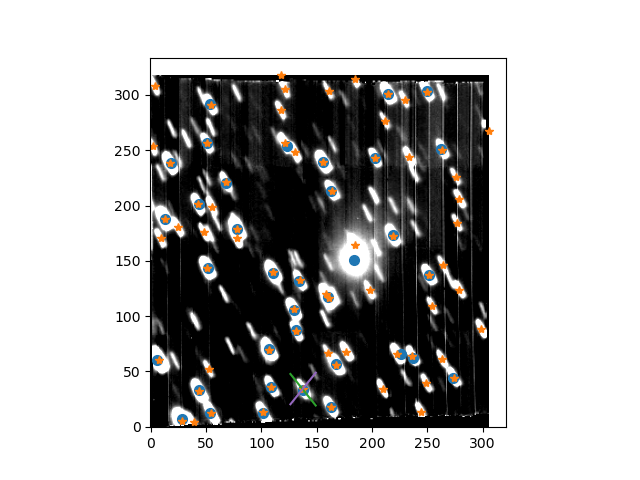

In [198]:
lx = np.arange(-11,12,0.1)
testx = lx + gaia['x'].iloc[10]
testy = lx*m+c + gaia['y'].iloc[10]
testyy = lx*-m+c + gaia['y'].iloc[10]
plt.figure()
plt.imshow(image,vmin=0,vmax=10,cmap='gray',origin='lower')
plt.plot(sourcex,sourcey,'o',ms=7)
plt.plot(gaia['x'],gaia['y'],'C1*')
plt.plot(testx,testy,'C2')
plt.plot(testx,testyy,'C4')

In [202]:
from scipy.interpolate import interp2d
interpolator = interp2d(np.arange(image.shape[1]), np.arange(image.shape[0]), image)

/var/folders/db/hdghk6ts5g11hr10jq0ss625nf1ny2/T/ipykernel_16608/2079977907.py:2: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interpolator = interp2d(np.arange(image.shape[1]), np.arange(image.shape[0]), image)


In [205]:
interp = interpolator(testx,testy)

/var/folders/db/hdghk6ts5g11hr10jq0ss625nf1ny2/T/ipykernel_16608/3072826851.py:1: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp = interpolator(testx,testy)


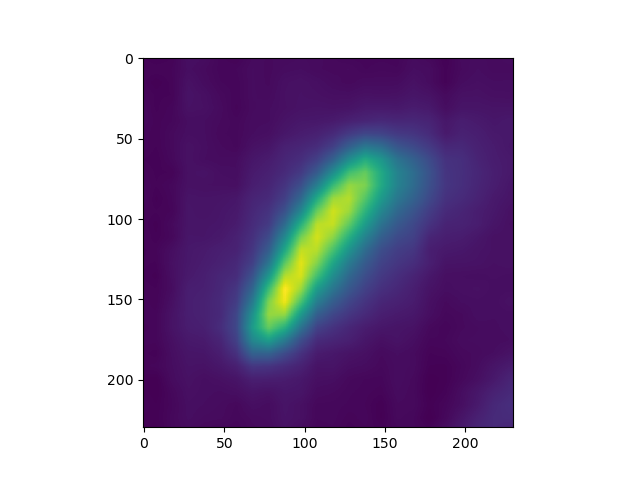

In [208]:
plt.figure()
plt.imshow(interp)

In [ ]:
griddata()

In [207]:
from scipy.interpolate import griddata

In [231]:
i = 25
lx = np.arange(-11,12,0.1)
testx = lx + gaia['x'].iloc[i]
testy = lx*m+c + gaia['y'].iloc[i]
testyy = lx*-m+c + gaia['y'].iloc[i]
dpix = np.sqrt((testx[0]-testx)**2+(testy[0]-testy)**2)

x = np.arange(0, image.shape[1])
y = np.arange(0, image.shape[0])
arr = np.ma.masked_invalid(image)
xx, yy = np.meshgrid(x, y)
#get only the valid values
x1 = xx[~arr.mask]
y1 = yy[~arr.mask]
newarr = arr[~arr.mask]
#print(x1,y1)

estimate = griddata((x1, y1), newarr.ravel(),
                          (testx,testy),method='linear')

In [252]:
ind = np.where(np.percentile(estimate[np.isfinite(estimate)],30) < estimate)[0]
trail_length = int(max(np.diff(ind))*1.2)

y_length = abs(int(trail_length/2 * np.sin(angle_radians)))
x_length = abs(int(trail_length/2 * np.cos(angle_radians)))

In [294]:
star_cuts = []
x = (gaia['x'].values + 0.5).astype(int); y = (gaia['y'].values + 0.5).astype(int)
for i in range(len(gaia)):
    if (x[i] +x_length+1 < image.shape[1]) & (x[i] - x_length >= 0) & (y[i] +y_length+1 < image.shape[1]) & (y[i] - y_length >= 0):
        dist = np.sqrt((x - x[i])**2 + (y - y[i])**2)
        dist[dist==0] = 100
        if np.min(dist) > 10:
            c = image[y[i]-y_length:y[i]+y_length+1,x[i]-x_length:x[i]+x_length+1]
            my,mx = np.where(np.max(c) == c)
            if (mx > 5) & (mx < c.shape[1]-5) & (my > 5) & (my < c.shape[0]-5):
                star_cuts += [c]
star_cuts = np.array(star_cuts)
norm_star_cuts = star_cuts / np.nanmax(star_cuts,axis=(1,2))[:,np.newaxis,np.newaxis]

In [291]:
star_cuts.shape

(43, 23, 19)

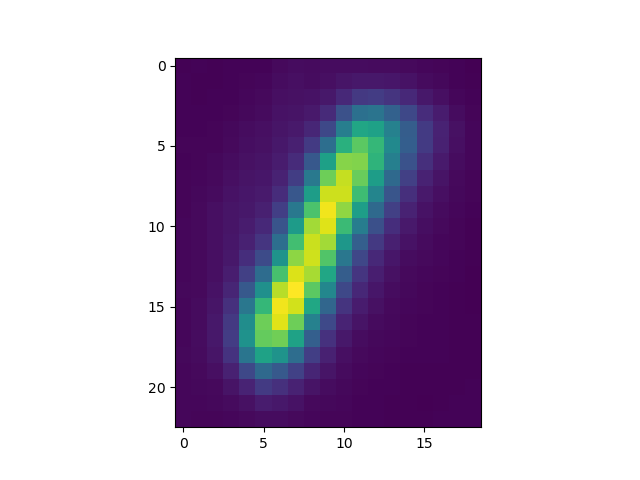

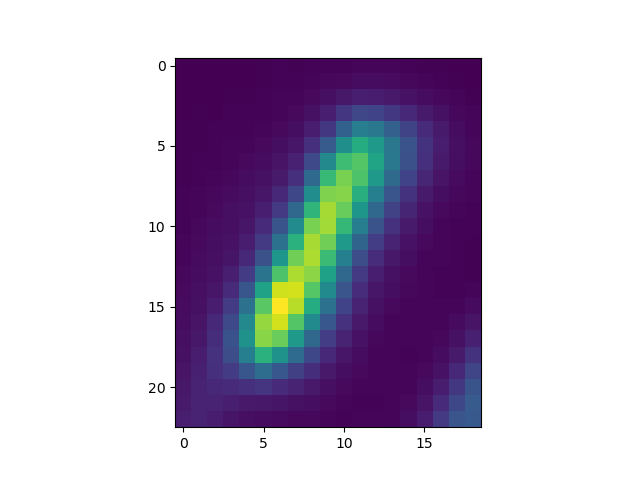

In [297]:
for i in range(2):
    plt.figure()
    plt.imshow(norm_star_cuts[i])

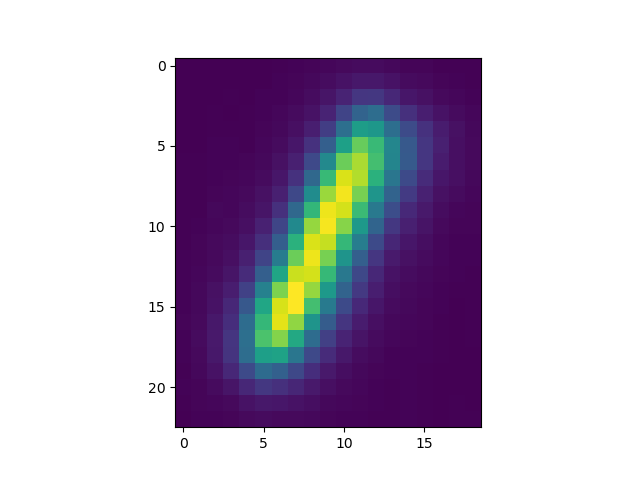

In [299]:
psf = np.nanmedian(norm_star_cuts,axis=0) / np.sum(np.nanmedian(norm_star_cuts,axis=0))
plt.figure()
plt.imshow(psf)

6      20.702034
8      16.921877
9      17.883831
10     18.304733
11     18.406145
         ...    
129    19.280191
133    20.405689
134    20.750364
135    20.726233
138    20.511391
Name: Gmag, Length: 70, dtype: float64

In [313]:
ind = (x >= 0) & (x < image.shape[1]) & (y >= 0) & (y < image.shape[0])
test = np.zeros_like(image)
test[y[ind],x[ind]] = 10**(-2/5*(gaia['Gmag'].values[ind]-25))
from scipy import signal
test = signal.fftconvolve(test, psf, mode='same')

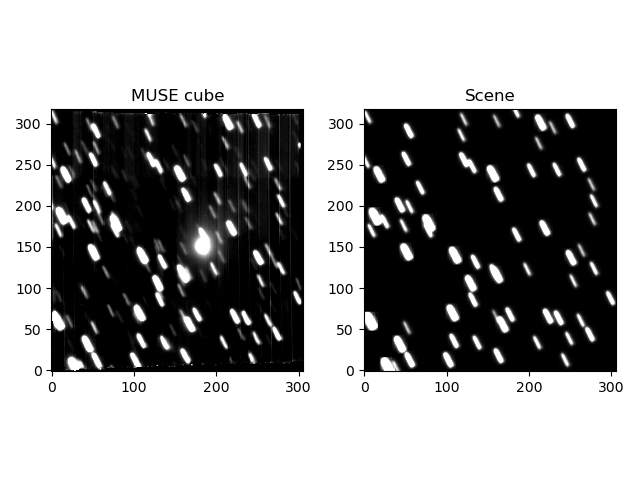

In [323]:
plt.figure()
plt.subplot(121)
plt.title('MUSE cube')
plt.imshow(image,vmin=0,vmax=np.percentile(image,95),cmap='gray',origin='lower')

plt.subplot(122)
plt.title('Scene')
plt.imshow(test,vmin=0,vmax=np.percentile(test,95),cmap='gray',origin='lower')
plt.tight_layout()
plt.savefig('first_scene.png',bbox_inches='tight')

In [302]:
image.shape

(318, 306)

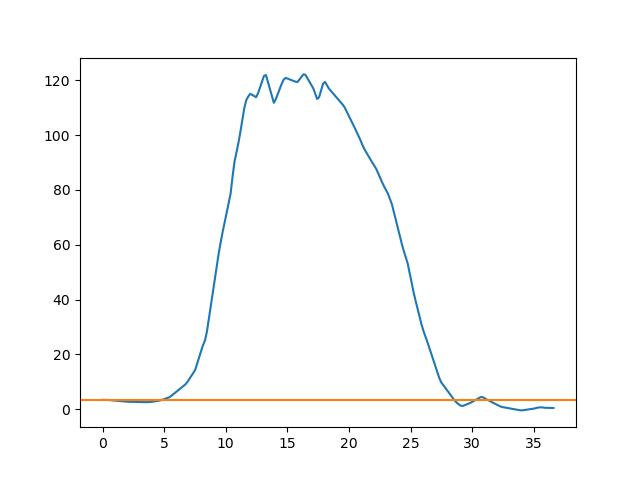

In [237]:
plt.figure()
plt.plot(dpix,estimate)
plt.axhline(np.percentile(estimate[np.isfinite(estimate)],30),color='C1')

In [17]:
G = gaia['Gmag'].values
B = gaia['BPmag'].values
R = gaia['RPmag'].values

gbp = G - B
grp = G - R
bprp = B - R

In [18]:
syn = pd.read_csv('ckmodel_Gaia_colors.csv')

In [19]:
diff = np.sqrt((gbp[:,np.newaxis] - syn['G-Bp'].values[np.newaxis,:])**2 + (grp[:,np.newaxis] - syn['G-Rp'].values[np.newaxis,:])**2 + (bprp[:,np.newaxis] - syn['Bp-Rp'].values[np.newaxis,:])**2)

In [20]:
inds = np.argmin(diff,axis=1)

In [21]:
matched = syn.iloc[inds]

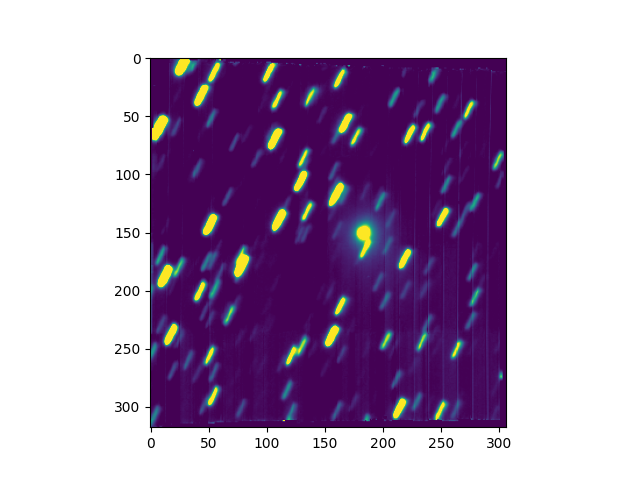

In [32]:
plt.figure()
plt.imshow(np.nanmean(data,axis=0),vmin=0,vmax=50)


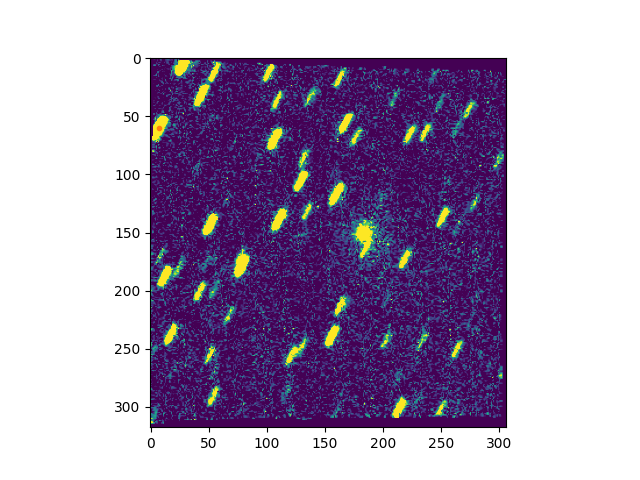

In [22]:
ind = np.argmin(gaia['Gmag'].values)
plt.figure()
plt.imshow(data[500],vmin=0,vmax=50)
plt.plot(int(gaia['x'].values[ind]),int(gaia['y'].values[ind]),'C1.')

In [23]:
ck = at.Table.read('/home/phys/astronomy/rri38/cube_scene/core/data/ck_spec/'+matched.iloc[ind]['model'], format='ascii')

In [24]:
x,y,lam = wcs.all_pix2world(0,0,np.arange(0,len(data)),0)

(3750.21533203125, 10350.21533203125)

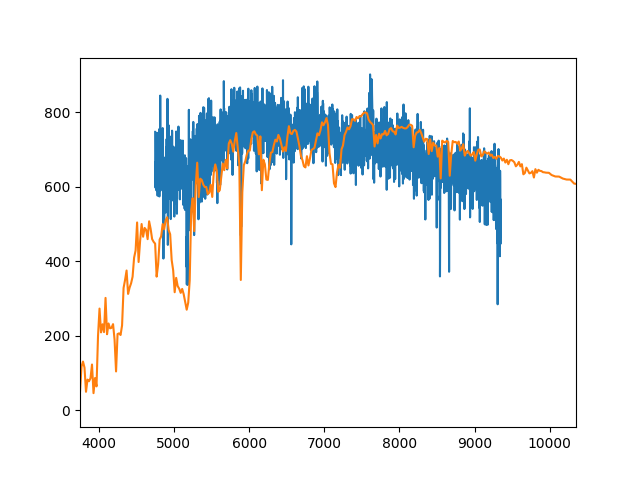

In [25]:
plt.figure()
plt.plot(lam*1e10,data[:,int(gaia['y'].values[58]),int(gaia['x'].values[58])])
plt.plot(ck['wave'],ck['flux']/np.nanmax(ck['flux'])*800)
plt.xlim(min(lam*1e10)-1000,max(lam*1e10)+1000)

In [26]:
mags = np.array([B,G,R]).T

In [27]:
cube_mangle(matched['model'].values,mags)

SVO
SVO
SVO
OrderedDict([('GAIA/GAIA3.Gbp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701e0460>, -2.094986479118612e+01)), ('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86702590d0>, -21.375993149393477)), ('GAIA/GAIA3.Grp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701ee100>, -21.859714513454705))])
[      nan 20.702034       nan]
1221
[nan nan nan ... nan nan nan]
OrderedDict([('GAIA/GAIA3.Gbp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701e0460>, -20.94986479118612)), ('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86702590d0>, -21.375993149393477)), ('GAIA/GAIA3.Grp', (<pysynphot.spectrum.ArraySpectralElement object at 0x7f86701ee100>, -21.859714513454705))])
[17.580181 16.921877 16.138477]
1221
(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.53583573e-23, 3.52062488e-23, 2.05931175e-23]]), {'allbands': None, 'ave_waves': None, 'bands': ['GAIA/GAIA3.Gbp', 'GAIA

ValueError: wave and flux arrays must be of equal length

In [ ]:
mags[i,1]

16.921877

In [ ]:
def Syn_mag(pbs,spec):
    mag = {}
    for pb in pbs:
        if spec is not None:
            syn_mag = synphot(spec,pbs[pb][0],zp=pbs[pb][1])
        else:
            syn_mag = np.nan
        mag[pb] = syn_mag
        
    return mag

def my_norm(Spec,pbs,mag):
    spec = deepcopy(Spec)
    m = Syn_mag(pbs,spec)
    m=m['GAIA/GAIA3.G']
    factor = 10**(-2/5*(mag-m))
    spec = S.ArraySpectrum(wave=spec.wave,waveunits=spec.waveunits,
                                   flux=spec.flux*factor,fluxunits=spec.fluxunits)
    return spec

In [ ]:
spec_files = matched['model'].values


svo_bp=['GAIA/GAIA3.G']

pbs = load_pbs(svo_bp,0,'AB',SVO=True)
mangled = []
for i in range(2):
    spec = at.Table.read(package_dir + spec_files[i], format='ascii')
    spec = S.ArraySpectrum(wave=spec['wave'].value,
                                    flux=spec['flux'].value,fluxunits='flam')
    print(pbs)
    print(mags[i])
    if np.isfinite(mags[i]).all():
        #flux = mangle_spectrum2(spec.wave,spec.flux,pbs,np.array([mags[i,1]]))
        spec2 = my_norm(spec,pbs,np.array([mags[i,1]]))
    else:
        flux = spec.flux * np.nan
    print(len(spec.wave))
    print(flux)

    #spec2 = S.ArraySpectrum(wave=spec.wave,
     #                               flux=flux,fluxunits='flam')
    mangled += [spec2]

SVO
OrderedDict([('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7fc61af039d0>, -21.375993149393477))])
[      nan 20.702034       nan]
1221
[nan nan nan ... nan nan nan]
OrderedDict([('GAIA/GAIA3.G', (<pysynphot.spectrum.ArraySpectralElement object at 0x7fc61af039d0>, -21.375993149393477))])
[17.580181 16.921877 16.138477]
1221
[nan nan nan ... nan nan nan]


In [ ]:
spec2.flux

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.28026005e-23, 1.22829591e-23, 7.18464555e-24])

In [ ]:
spec.flux

array([0.      , 0.      , 0.      , ..., 0.037838, 0.020382, 0.011922])

In [ ]:
pbs

OrderedDict([('GAIA/GAIA3.Gbp',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fc6e90de790>,
               -20.94986479118612)),
             ('GAIA/GAIA3.G',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fc61bea6df0>,
               -21.375993149393477)),
             ('GAIA/GAIA3.Grp',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fc61be8c700>,
               -21.859714513454705))])

In [37]:
mags[i]

array([17.580181, 16.921877, 16.138477])

In [38]:
flux

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.53583573e-23, 3.52062488e-23, 2.05931175e-23]]),
 {'allbands': None,
  'ave_waves': None,
  'bands': ['GAIA/GAIA3.Gbp', 'GAIA/GAIA3.G', 'GAIA/GAIA3.Grp'],
  'resp_rats': None,
  'mfactors': None},
 array([ 1.43240369, -1.0271856 ,  1.37540149]))

In [65]:
spec2.fluxunits

(3750.21533203125, 10350.21533203125)

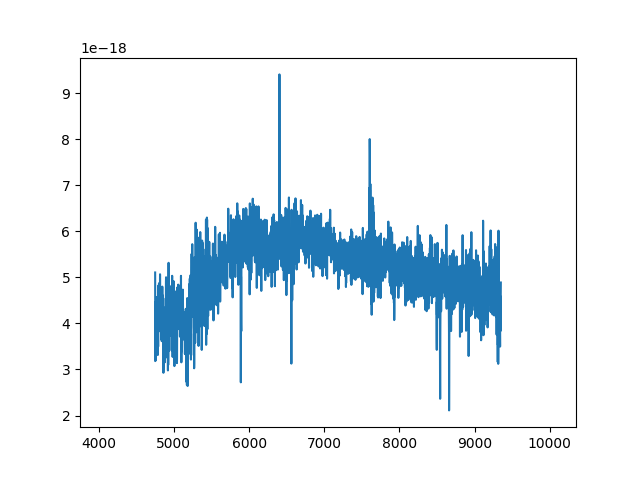

In [74]:
plt.figure()
plt.plot(lam*1e10,data[:,int(gaia['y'].values[1]),int(gaia['x'].values[1])]*10**-20)
plt.plot(spec2.wave,spec2.flux)
#plt.plot(spec.wave,spec.flux)

#plt.plot(ck['wave'],ck['flux']/np.nanmax(ck['flux'])*800)
plt.xlim(min(lam*1e10)-1000,max(lam*1e10)+1000)

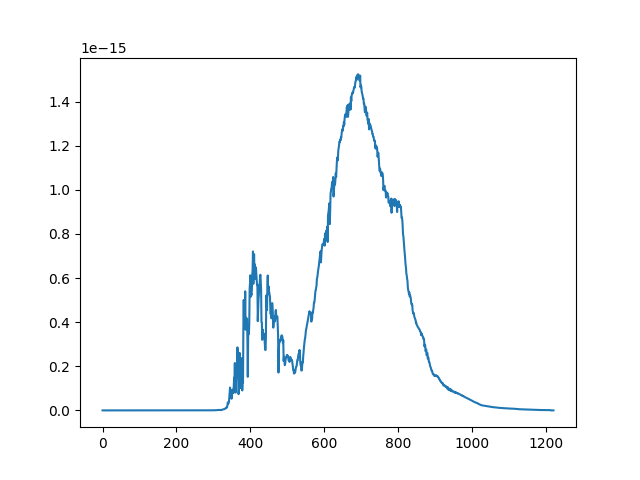

In [32]:
plt.figure()
plt.plot(flux[0][0])

In [266]:
G = cat['Gmag'].values
B = cat['BPmag'].values
R = cat['RPmag'].values

In [1]:
wcs

NameError: name 'wcs' is not defined

In [26]:
ck['wave'].value

array([9.09000015e+01, 9.35000000e+01, 9.60999985e+01, ...,
       1.20000000e+06, 1.40000000e+06, 1.60000000e+06])

In [69]:
hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2020-04-14T12:21:53' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
TELESCOP= 'ESO-VLT-U4'         / ESO <TEL>                                      
INSTRUME= 'MUSE    '           / Instrument used.                               
RA      =           192.866371 / [deg] 12:51:27.9 RA (J2000) pointing           
DEC     =            -69.13484 / [deg] -69:08:05.4 DEC (J2000) pointing         
EQUINOX =                200